# 🐾 AnimalCLEF2025 Competition: Official Starter notebook + Metrics Implementation & Baseline evaluation

The **Goal of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) competition is to identify individual animal (lynxes, salamanders and sea turtles) in photos. This notebook visualize the provided dataset and propose a baseline solution, based on the state-of-the-art re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). The dataset is split into the database and query sets. For each image from the query set, the goal is to:

- Predict whether the depicted individual is in the database.
- If no, the prediction is `new_individual`.
- If yes, the prediction should be the same as the individual in the database.

## Dependencies instalation
For the competition we provide two Python packages for loading and preprocessing of available datasets ([wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets)) and tools / method for animal re-identification ([wildlife-tools](https://github.com/WildlifeDatasets/wildlife-tools)).

In [2]:
!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /tmp/pip-req-build-9vycy4vs
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /tmp/pip-req-build-9vycy4vs
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 959c6c01a8317ed4f162ebfdf4b5e63faad60228
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wildlife-datasets: filename=wildlife_datasets-1.0.5-py3-none-any.whl size=88207 sha256=dac03cb1295b266d9e13acd10b0cfb307a6320f75d2045618a350e955a0b7848
  Stored in directory: /tmp/pip-ephem-wheel-cache-_cqi6_7m/wheels/c5/e9/19/815dc8ac1a073b6769942e201b8776a681537b3da4bc2c60ab
Successfully built wi

# Metrics Definition

In [3]:
import numpy as np
from typing import List, Union

def baks_compute(
        y_true: Union[List, np.ndarray],
        y_pred: Union[List, np.ndarray],
        identity_test_only: Union[List, np.ndarray]
    ) -> float:
    """Computes BAKS (balanced accuracy on known samples).
    
    Focuses only on samples with known identities (not in identity_test_only).
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        identity_test_only: Labels of unknown identities (only in test set)
        
    Returns:
        Balanced accuracy score for known samples
    """
    # Convert inputs to numpy arrays with object dtype to handle mixed types
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    identity_test_only = np.array(identity_test_only, dtype=object)
    
    # Filter out unknown samples
    mask = ~np.isin(y_true, identity_test_only)
    y_true_known = y_true[mask]
    y_pred_known = y_pred[mask]
    
    if len(y_true_known) == 0:
        return 0.0
    
    # Get unique classes in the filtered true labels
    unique_classes = np.unique(y_true_known)
    n_classes = len(unique_classes)
    
    # Compute per-class accuracy and average
    class_accuracies = []
    for cls in unique_classes:
        cls_mask = (y_true_known == cls)
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(y_pred_known[cls_mask] == cls)
            class_accuracies.append(cls_acc)
    
    # Return the balanced accuracy (mean of per-class accuracies)
    return np.mean(class_accuracies) if class_accuracies else 0.0

def baus_compute(
        y_true: Union[List, np.ndarray],
        y_pred: Union[List, np.ndarray],
        identity_test_only: Union[List, np.ndarray],
        new_class: Union[int, str]
    ) -> float:
    """Computes BAUS (balanced accuracy on unknown samples).
    
    Focuses only on samples with unknown identities (in identity_test_only).
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        identity_test_only: Labels of unknown identities (only in test set)
        new_class: Label used for identifying unknown samples
        
    Returns:
        Balanced accuracy score for unknown samples
    """
    # Convert inputs to numpy arrays with object dtype to handle mixed types
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    identity_test_only = np.array(identity_test_only, dtype=object)
    
    # Filter to include only unknown samples
    mask = np.isin(y_true, identity_test_only)
    y_true_unknown = y_true[mask]
    y_pred_unknown = y_pred[mask]
    
    if len(y_true_unknown) == 0:
        return 0.0
    
    # Get unique unknown classes
    unique_unknown_classes = np.unique(y_true_unknown)
    
    # For each unknown class, check if they were correctly predicted as new_class
    class_accuracies = []
    for cls in unique_unknown_classes:
        cls_mask = (y_true_unknown == cls)
        if np.sum(cls_mask) > 0:
            # For unknown samples, correct prediction is new_class
            cls_acc = np.mean(y_pred_unknown[cls_mask] == new_class)
            class_accuracies.append(cls_acc)
    
    # Return the balanced accuracy (mean of per-class accuracies)
    return np.mean(class_accuracies) if class_accuracies else 0.0


def compute_geometric_mean(baks, baus):
    return np.sqrt(baks * baus)

## Dependencies import
We load all the required packages and then define the function `create_sample_submission`, which converts provided predictions and a submission file for the competition.

In [4]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

We need to specify the `root`, where the data are stored and then two image transformations. 
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [5]:
root = '/kaggle/input/animal-clef-2025'
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

# Import the dataset

When importing the database and filtering it, we can see that the salamander species are missing.

In [6]:
from wildlife_datasets import datasets, splits
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)
df = dataset.df 
df = df[df['split'] == 'database']
df.species.value_counts()

species
loggerhead turtle    8729
lynx                 2957
Name: count, dtype: int64

In [7]:
df.isna().value_counts()

image_id  identity  path   date   orientation  species  split  dataset
False     False     False  False  False        False    False  False      8526
                           True   False        False    False  False      2957
                           False  False        True     False  False      1384
                                  True         False    False  False       203
                           True   False        True     False  False         4
Name: count, dtype: int64

In [8]:
df.fillna('salamander', inplace=True)
df.species.value_counts()

<ipython-input-8-05ec05b7b4b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna('salamander', inplace=True)


species
loggerhead turtle    8729
lynx                 2957
salamander           1388
Name: count, dtype: int64

# Splitting the database into train and validation(Known identities)
For splitting we can use wildlife tools, that provide direct implementations of open-set data split and many more.

In [9]:
splitter = splits.OpenSetSplit(0.8, 0.1)
for idx_train, idx_test in splitter.split(df):
    splits.analyze_split(df, idx_train, idx_test)

Split: time-unaware open-set
Samples: train/test/unassigned/total = 10272/2802/0/13074
Classes: train/test/unassigned/total = 1007/811/0/1102
Samples: train only/test only        = 291/1356
Classes: train only/test only/joint  = 291/95/716

Fraction of train set     = 78.57%
Fraction of test set only = 10.37%


In [10]:
df_train, df_test = df.loc[idx_train], df.loc[idx_test]
len(df_train)
len(df_test)

2802

In [11]:
df_train

,image_id,identity,path,date,orientation,species,split,dataset
3083,3083,LynxID2025_lynx_00,images/LynxID2025/database/ca193791069939ef893...,salamander,right,lynx,database,LynxID2025
2938,2938,LynxID2025_lynx_00,images/LynxID2025/database/c0946cd20fd6ba61a62...,salamander,right,lynx,database,LynxID2025
534,534,LynxID2025_lynx_00,images/LynxID2025/database/2346ca29481a60d3880...,salamander,left,lynx,database,LynxID2025
1113,1113,LynxID2025_lynx_00,images/LynxID2025/database/47a04afea9a27f2e998...,salamander,left,lynx,database,LynxID2025
3458,3458,LynxID2025_lynx_00,images/LynxID2025/database/e380653385d8f1fd317...,salamander,left,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
14708,14708,SeaTurtleID2022_t610,images/SeaTurtleID2022/database/turtles-data/d...,2022-07-08,left,loggerhead turtle,database,SeaTurtleID2022
14695,14695,SeaTurtleID2022_t610,images/SeaTurtleID2022/database/turtles-data/d...,2022-07-02,topleft,loggerhead turtle,database,SeaTurtleID2022
14696,14696,SeaTurtleID2022_t610,images/SeaTurtleID2022/database/turtles-data/d...,2022-07-02,left,loggerhead turtle,database,SeaTurtleID2022
14704,14704,SeaTurtleID2022_t610,images/SeaTurtleID2022/database/turtles-data/d...,2022-07-08,top,loggerhead turtle,database,SeaTurtleID2022


In [12]:
training_dataloader = dataset.get_subset(df_train.index)
val_dataloader = dataset.get_subset(df_test.index)


training_dataloader.transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
training_dataloader.transform

val_dataloader.transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
val_dataloader.transform

Compose(
    Resize(size=[384, 384], interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

# Inference with MegaDescriptor

Here we perform the provided inference but with the freshly splitted dataset.

In [13]:
name = 'hf-hub:BVRA/MegaDescriptor-L-384'
device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)
extractor = DeepFeatures(model, device=device, batch_size=32, num_workers=0)
features_database = extractor(training_dataloader)
features_query = extractor(val_dataloader)
n_query = len(val_dataloader)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████| 88/88 [04:50<00:00,  3.30s/it]


Here we extract the similarity between the images. The similarity equals to the cosine similarity between the corresponding feature vectors. Since the cosine similarity reflects the angle between the feature vectors, high similarity means that the feature vectors are close to each other and should depict the same individual.

In [14]:
similarity = CosineSimilarity()(features_query, features_database)

For each query image we extract the closest image as predicted by MegaDescriptor. Their indices are stored in `pred_idx` and the similarity score of the top match in `pred_scores`.

In [15]:
pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

This is sufficient to perform predictions as shown below in `predictions`. However, we also need to predict whether the individual is new. We utilize the simplest idea and predict that the individual is new whenever the similarity score of the top prediction is below a certain threshold which we arbirtarily selected as 0.6. We create a submission file, which scores 30.0% on the public leaderboard.

In [17]:
new_individual = 'new_individual'
threshold = 0.6
labels = training_dataloader.labels_string
predictions = labels[pred_idx]
predictions[pred_scores < threshold] = new_individual

# Evaluation

## Find unseen values

In [18]:
unseen_ids = []
all_ids = df['identity'].unique()

for i in all_ids:
    if i in val_dataloader.metadata['identity'].tolist():
        if i not in training_dataloader.metadata['identity'].tolist():
            unseen_ids.append(i)

## Calculate BAUS, BAKS and their mean

In [29]:
val_true_labels = val_dataloader.labels_string
baks_score = baks_compute(val_true_labels, predictions, unseen_ids)
baus_score = baus_compute(val_true_labels, predictions, unseen_ids, "new_individual")
geo_mean = compute_geometric_mean(baks_score, baus_score)

print(f"Balanced Accuracy Known Samples (BAKS): {baks_score:.4f}")
print(f"Balanced Accuracy Unknown Samples (BAUS): {baus_score:.4f}")
print(f"Geometric Mean (BAKS & BAUS): {geo_mean:.4f}")

Balanced Accuracy Known Samples (BAKS): 0.4998
Balanced Accuracy Unknown Samples (BAUS): 0.4778
Geometric Mean (BAKS & BAUS): 0.4887


## Visualizing the metrics by threshold

In [34]:
thresholds = np.arange(0.1, 0.9, 0.05)
results = []
labels = np.array(training_dataloader.labels_string)


for threshold in thresholds:
    predictions = labels[pred_idx].copy()
    predictions[pred_scores < threshold] = 'new_individual'

    baks = baks_compute(val_true_labels, predictions, unseen_ids)
    baus = baus_compute(val_true_labels, predictions, unseen_ids, 'new_individual')
    geo_mean = compute_geometric_mean(baks, baus)
    results.append((threshold, baks, baus, geo_mean))

    print(f"Threshold: {threshold:.2f} | BAKS: {baks:.4f} | BAUS: {baus:.4f} | GEO_MEAN: {geo_mean:.4f}")

Threshold: 0.10 | BAKS: 0.5670 | BAUS: 0.0000 | GEO_MEAN: 0.0000
Threshold: 0.15 | BAKS: 0.5670 | BAUS: 0.0000 | GEO_MEAN: 0.0000
Threshold: 0.20 | BAKS: 0.5670 | BAUS: 0.0035 | GEO_MEAN: 0.0446
Threshold: 0.25 | BAKS: 0.5670 | BAUS: 0.0107 | GEO_MEAN: 0.0779
Threshold: 0.30 | BAKS: 0.5670 | BAUS: 0.0355 | GEO_MEAN: 0.1419
Threshold: 0.35 | BAKS: 0.5643 | BAUS: 0.1029 | GEO_MEAN: 0.2410
Threshold: 0.40 | BAKS: 0.5620 | BAUS: 0.1926 | GEO_MEAN: 0.3290
Threshold: 0.45 | BAKS: 0.5586 | BAUS: 0.2820 | GEO_MEAN: 0.3969
Threshold: 0.50 | BAKS: 0.5471 | BAUS: 0.3481 | GEO_MEAN: 0.4364
Threshold: 0.55 | BAKS: 0.5317 | BAUS: 0.4115 | GEO_MEAN: 0.4678
Threshold: 0.60 | BAKS: 0.4998 | BAUS: 0.4778 | GEO_MEAN: 0.4887
Threshold: 0.65 | BAKS: 0.4751 | BAUS: 0.5714 | GEO_MEAN: 0.5210
Threshold: 0.70 | BAKS: 0.4452 | BAUS: 0.6748 | GEO_MEAN: 0.5481
Threshold: 0.75 | BAKS: 0.3991 | BAUS: 0.8217 | GEO_MEAN: 0.5727
Threshold: 0.80 | BAKS: 0.3467 | BAUS: 0.9221 | GEO_MEAN: 0.5654
Threshold: 0.85 | BAKS: 0

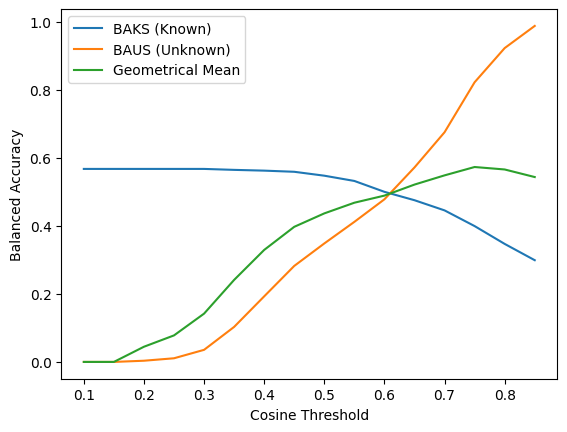

In [35]:
import matplotlib.pyplot as plt

thresholds, baks_scores, baus_scores, geo = zip(*results)
plt.plot(thresholds, baks_scores, label='BAKS (Known)')
plt.plot(thresholds, baus_scores, label='BAUS (Unknown)')
plt.plot(thresholds, geo, label='Geometrical Mean')
plt.xlabel('Cosine Threshold')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.show()